# **Mandatory Assignment 1**
## *Natural Language Processing and Text Analytics (KAN-CDSCO1002U)*
Group: MA-01 1

Student IDs: 185912, 160363, xxx & xxx

Dataset: sample.xlsx

## Part 1: Mandatory Question

**Sentences 1, 3, and 4** share prepositional-phrase attachment ambiguity. The prepositional phrase “with + noun phrase” can attach to two different heads in the syntax: it can attach to the verb phrase, where it describes how the action is performed (typically an instrument/means reading), or it can attach to the noun phrase, where it describes which noun is being referred to (a modifier reading). In this setting, an ambiguous sentence is one where both attachments are grammatically possible, so the sentence allows two distinct interpretations even if one is less realistic.

**Sentence 2** also has attachment ambiguity, but it is a temporal PP attachment ambiguity. The time phrase “on Saturday” can attach either to the higher verb “decided” (the deciding happened on Saturday) or to the embedded verb “leave” (the leaving happens on Saturday). In this case, the sentence is ambiguous because the time PP has two structurally valid attachment sites, leading to two different meanings.

1. The girl attacked the boy with the book.

* She used the book to attack him.
* She attacked the boy who had the book.

2. We decided to leave on Saturday.

* The decision was made on Saturday.
* On Saturday they will leave.

3. I saw a man with a briefcase.

* I saw a man who had a briefcase.
* I was carrying a briefcase when I saw the man.

4. I saw the planet with a telescope.

* I used a telescope to see the planet.
* I saw the planet that had a telescope.

We also verified the dependency links in the provided Hugging Face parse tree generator; the attachment difference matches spaCy’s dependency parse. When comparing the dependency structures, the key difference is what the preposition “with” is linked to.

In **sentence 3** “I saw a man with a briefcase”, **with** is attached under **man**, meaning the prepositional phrase modifies the noun: it describes *which man* (the man who has a briefcase).

In **sentence 4** “I saw the planet with a telescope”, **with** is attached directly under **saw**, meaning the prepositional phrase modifies the verb: it describes *how* the seeing happened (using a telescope as an instrument).

This illustrates the same core ambiguity type (prepositional phrase attachment): syntactically, a “with + NP” phrase can attach either to a nearby noun (NP-modifier) or to the verb (VP-modifier), and the surface form alone does not force one interpretation.


Sentence 3: Tree output (dependency structure)

```
saw
├─ I
└─ man
   ├─ a
   └─ with
      └─ briefcase
         └─ a
```

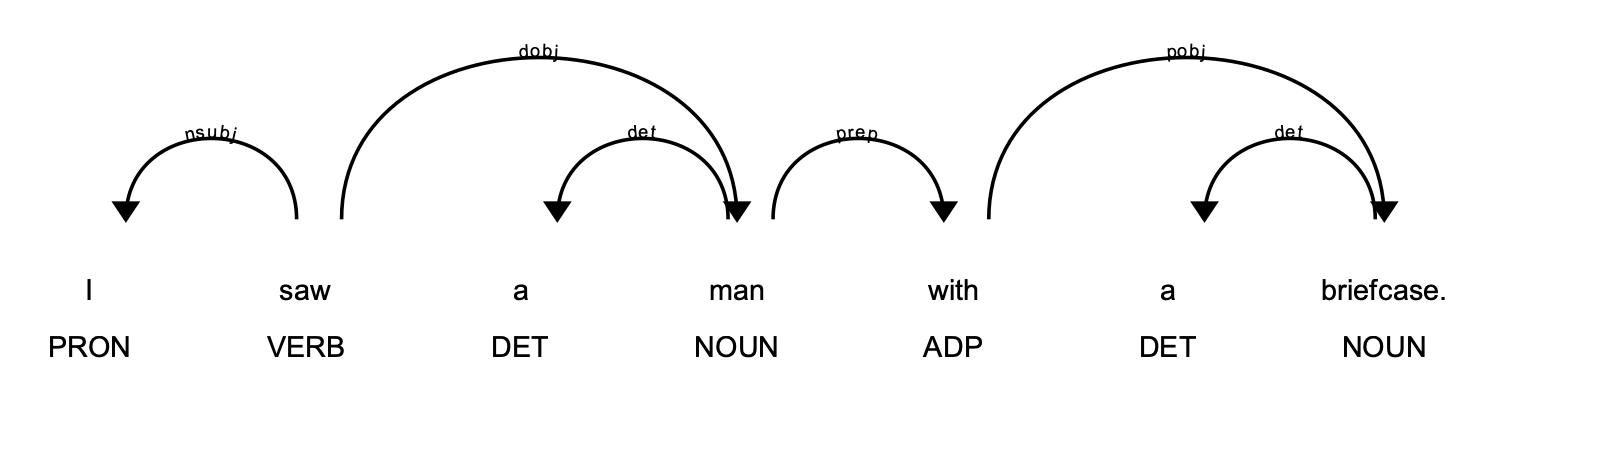

In [37]:
from IPython.display import Image, display

display(Image("Illustrations/s3.png"))

Sentence 4: Tree output (dependency structure)

```
saw
├─ I
├─ planet
│  └─ the
└─ with
   └─ telescope
      └─ a
```

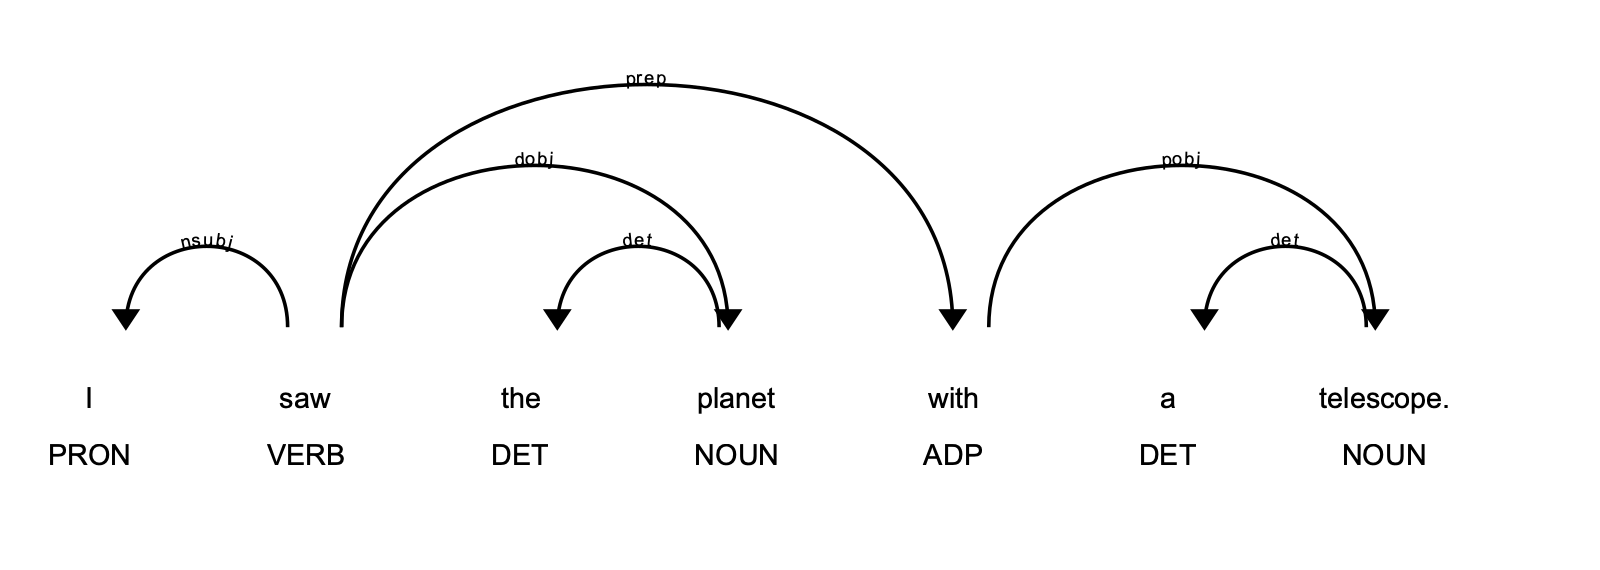

In [38]:
display(Image("Illustrations/s4.png"))

## Part 2: Linguistic Analysis of a Text Corpus Using spaCy

This report analyzes linguistic patterns in a corpus of 100 SOS messages using spaCy. The analysis consists of (i) constructing and preprocessing the corpus, (ii) applying Part-of-Speech (POS) tagging and Named Entity Recognition (NER), (iii) computing frequency distributions for POS tags and entity labels, and (iv) interpreting the most common patterns to describe the structure and information content of SOS messages.

### Introduction

The dataset consists of short SOS-style messages that request urgent medical resources and assistance. Because these messages are typically brief, information-dense, and written in informal formats, they provide a useful example for corpus-based linguistic analysis. Using spaCy, we examine the distribution of POS tags and named entities to understand what types of information dominate these messages (e.g., resources, locations, institutions, and numerical medical details).

### Methodology and Results

We constructed the corpus by extracting the “SOS Tweet / SOS Message” column from the Excel file, removing missing entries, and converting all messages to strings. Following the preprocessing principles from Lecture 2, we normalized the text using lightweight regex cleaning (removing URLs, redaction placeholders, non-informative characters, and normalizing whitespace). For POS analysis, we created a processed representation by tokenizing with spaCy and removing stopwords, punctuation, and single-character tokens to reduce anonymization artifacts. For NER, we used a separate, case-preserved representation to retain contextual cues that improve entity detection. We then applied spaCy’s pretrained English model to compute frequency distributions (counts and percentages) for POS tags and entity labels.

Normalization techniques applied are listed below to make the preprocessing pipeline transparent and reproducible:
* Lowercasing
* URL removal (regex-based cleaning)
* Redaction placeholder removal
* Special character filtering (keeping only alphanumeric characters and selected punctuation)
* Whitespace normalization (removal of extra spaces)
* Basic punctuation spacing correction (e.g., separating stuck tokens like “help.urgent”)
* Stopword removal
* Punctuation removal
* Single-character token filtering (noise reduction from anonymization artifacts)

We processed the corpus with spaCy’s pretrained English model to assign POS tags to tokens and to detect named entities. POS statistics were computed from the processed text representation, while NER was computed from the case-preserved representation to maintain signals important for entity recognition. Frequencies are reported as both counts and percentages.

In [39]:
# Task 1: Prepare the Corpus (lecture-aligned + small practical improvements)

import pandas as pd
import spacy
import re

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# ---- 1) Load data ----
df = pd.read_excel("Data/sample.xlsx", header=8)

sos_col = "SOS Tweet / SOS Message"

# Keep only the SOS column, drop missing once (prevents index misalignment later)
df_clean = df[[sos_col]].dropna().copy()
df_clean[sos_col] = df_clean[sos_col].astype(str)

# Corpus as a list of documents (strings)
messages = df_clean[sos_col].tolist()

print(f"Total messages: {len(messages)}")
if messages:
    print(f"Sample message:\n{messages[0][:200]}...")

# ---- 2) Preprocessing / normalization (for frequency/POS analysis) ----
def preprocess(text: str) -> str:
    # Normalize case (helps frequency-based analysis; may reduce NER quality later)
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove redaction placeholders like [Redacted Mention], [Redacted Address], etc.
    text = re.sub(r"\[redacted\s+\w+\]", "", text, flags=re.IGNORECASE)

    # Keep letters, digits, whitespace, and a small set of punctuation
    text = re.sub(r"[^a-z0-9\s.,!?'\-]", " ", text)

    # Fix cases like "help.urgent" -> "help. urgent"
    text = re.sub(r"\.(?=[a-z])", ". ", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

df_clean["cleaned_text"] = df_clean[sos_col].apply(preprocess)

# ---- 2b) NER-friendly text (keep casing + keep context) ----
def preprocess_for_ner(text: str) -> str:
    # Keep original casing for NER
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"\[redacted\s+\w+\]", "", text, flags=re.IGNORECASE)
    text = re.sub(r"[^A-Za-z0-9\s.,!?'\-]", " ", text)
    text = re.sub(r"\.(?=[A-Za-z])", ". ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_clean["ner_text"] = df_clean[sos_col].apply(preprocess_for_ner)

# ---- 3) Stopword removal using spaCy (for frequency/POS analysis) ----
def remove_stopwords(text: str) -> str:
    doc = nlp(text)
    tokens = [
        token.text
        for token in doc
        if not token.is_stop
        and not token.is_punct
        and token.text.strip()
        and len(token.text) > 1
    ]
    return " ".join(tokens)

df_clean["processed_text"] = df_clean["cleaned_text"].apply(remove_stopwords)

# ---- 4) Quick sanity check ----
print("\nPreprocessing complete.")
if messages:
    print(f"\nBefore:\n{messages[0][:100]}...")
    print(f"\nAfter:\n{df_clean['processed_text'].iloc[0][:100]}...")

Total messages: 100
Sample message:
my relative B************n who is from bagmara jharkhand is tested positive for corona and is admitted in recovery nourshing home bardmaan West Bengal.He is not getting sufficient treatment and his he...

Preprocessing complete.

Before:
my relative B************n who is from bagmara jharkhand is tested positive for corona and is admitt...

After:
relative bagmara jharkhand tested positive corona admitted recovery nourshing home bardmaan west ben...


In [40]:
import pandas as pd
from collections import Counter

# -----------------------------
# POS Tag Distribution (use processed_text)
# -----------------------------
pos_counts = Counter()
token_total = 0

for doc in nlp.pipe(df_clean["processed_text"].tolist(), batch_size=50):
    for tok in doc:
        if tok.is_space or tok.is_punct:
            continue
        pos_counts[tok.pos_] += 1
        token_total += 1

pos_df = (
    pd.DataFrame(pos_counts.items(), columns=["POS Tag", "Count"])
    .sort_values("Count", ascending=False)
    .reset_index(drop=True)
)
pos_df["Percent"] = (pos_df["Count"] / token_total * 100).round(2)

print(f"\nPOS Tag Distribution (Total tokens counted: {token_total})")
print(pos_df.to_string(index=False))

# -----------------------------
# Named Entity Distribution (use ner_text for better NER)
# -----------------------------
ent_counts = Counter()
ent_total = 0
examples_per_label = 5
ent_examples = {}

DOMAIN_NONPERSON = {"spo2", "covid", "covid19", "icu", "ct", "o2", "oxygen"}

def keep_entity(ent) -> bool:
    txt = ent.text.strip()
    low = txt.lower()
    if ent.label_ == "PERSON":
        if any(ch.isdigit() for ch in txt):
            return False
        if low in DOMAIN_NONPERSON:
            return False
        if "hospital" in low or "district" in low or "hosp" in low:
            return False
    return True

for doc in nlp.pipe(df_clean["ner_text"].tolist(), batch_size=50):
    for ent in doc.ents:
        if not keep_entity(ent):
            continue

        label = ent.label_
        ent_counts[label] += 1
        ent_total += 1

        if label not in ent_examples:
            ent_examples[label] = []
        ex = ent.text.strip()

        if ex and ex not in ent_examples[label] and len(ent_examples[label]) < examples_per_label:
            ent_examples[label].append(ex)

ent_df = (
    pd.DataFrame(ent_counts.items(), columns=["Entity Type", "Count"])
    .sort_values("Count", ascending=False)
    .reset_index(drop=True)
)
ent_df["Percent"] = (ent_df["Count"] / ent_total * 100).round(2) if ent_total else 0

print(f"\nNamed Entity Distribution (Total entities found: {ent_total})")
print(ent_df.to_string(index=False))

print("\nEntity label examples:")
for label in ent_df["Entity Type"].tolist():
    exs = ent_examples.get(label, [])
    if exs:
        print(f"  {label}: {exs}")


POS Tag Distribution (Total tokens counted: 1764)
POS Tag  Count  Percent
   NOUN    744    42.18
  PROPN    409    23.19
   VERB    216    12.24
    NUM    166     9.41
    ADJ    148     8.39
    ADV     34     1.93
   INTJ     16     0.91
    ADP     10     0.57
    AUX      9     0.51
      X      5     0.28
  PUNCT      2     0.11
   PART      2     0.11
   PRON      2     0.11
    DET      1     0.06

Named Entity Distribution (Total entities found: 399)
Entity Type  Count  Percent
        ORG    109    27.32
   CARDINAL    100    25.06
       DATE     59    14.79
     PERSON     55    13.78
        GPE     47    11.78
    PRODUCT      9     2.26
       NORP      3     0.75
      EVENT      3     0.75
        FAC      3     0.75
        LAW      2     0.50
   QUANTITY      2     0.50
    ORDINAL      2     0.50
        LOC      2     0.50
    PERCENT      1     0.25
       TIME      1     0.25
WORK_OF_ART      1     0.25

Entity label examples:
  ORG: ['Nadiad', 'SOSDehradun Pla

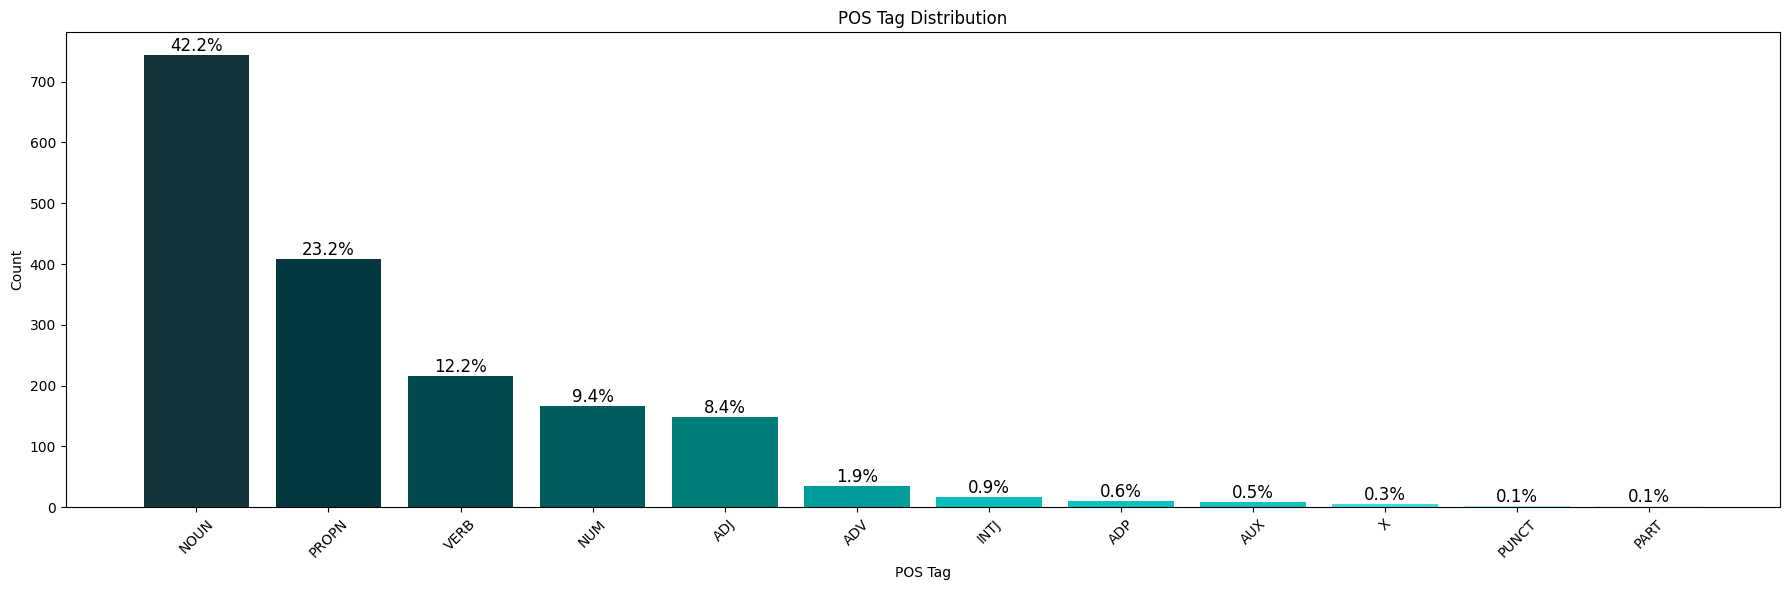

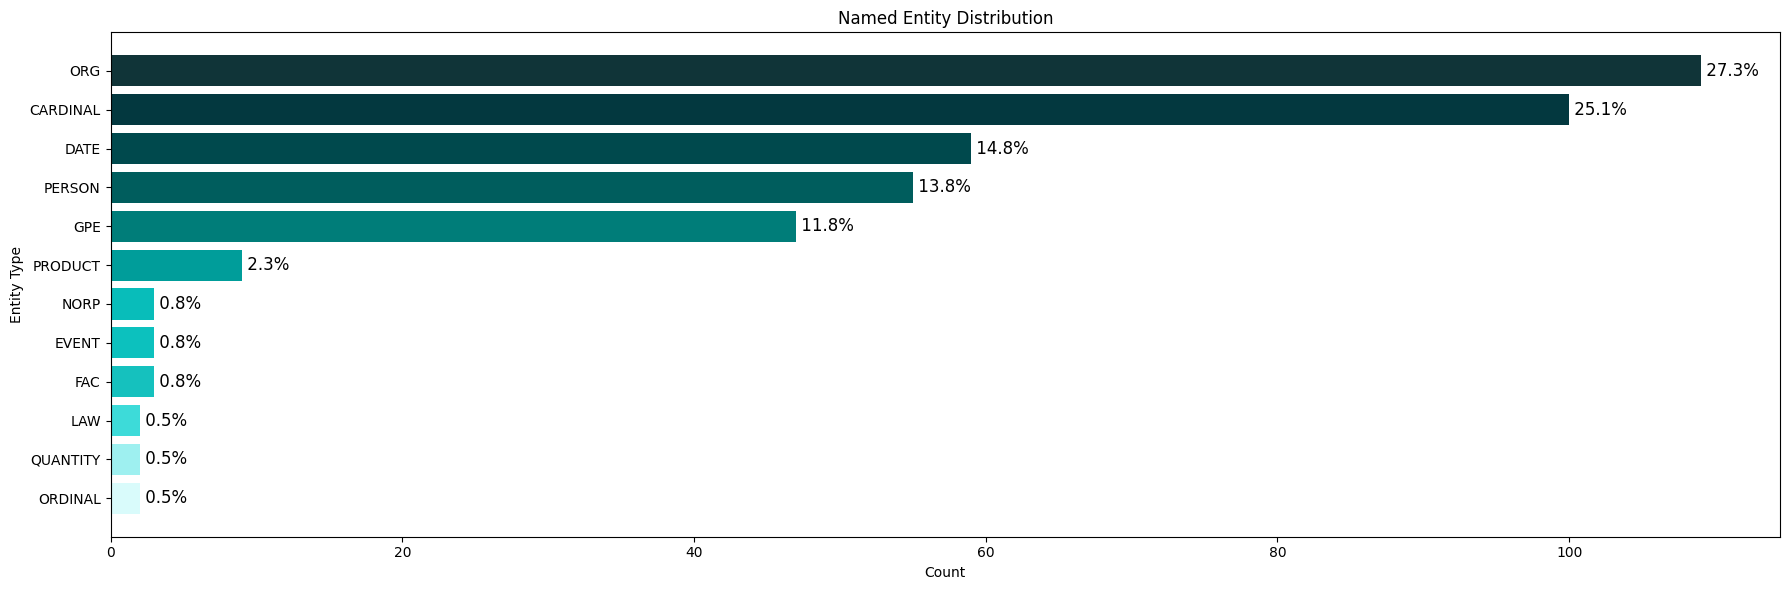


Top 10 tokens for POS = NOUN:
  oxygen: 80
  bed: 49
  level: 38
  contact: 37
  help: 31
  age: 27
  patient: 22
  ventilator: 19
  icu: 17
  location: 12

Top 10 tokens for POS = PROPN:
  delhi: 23
  spo2: 20
  urgent: 18
  icu: 17
  patient: 13
  sir: 12
  cylinder: 10
  hospital: 9
  o2: 9
  bed: 8

Top 10 tokens for POS = VERB:
  need: 32
  help: 24
  required: 14
  needs: 11
  admitted: 6
  leads: 5
  needed: 5
  getting: 4
  patient: 4
  require: 4


In [43]:
import matplotlib.pyplot as plt
from collections import Counter

PALETTE = [
    "#103438",  # Teal 100
    "#03383f",  # Teal 90
    "#00494D",  # Teal 80
    "#005d5d",  # Teal 70
    "#007d79",  # Teal 60
    "#009d9a",  # Teal 50
    "#08bdba",  # Teal 45
    "#0cc1be",  # Teal 40
    "#15c1be",  # Teal 35
    "#3ddbd9",  # Teal 30
    "#9ef0f0",  # Teal 20
    "#d9fbfb",  # Teal 10
]

# -----------------------------
# Plots (POS and NER)
# -----------------------------
top_n_pos = 12
top_n_ent = 12

pos_plot = pos_df.head(top_n_pos).copy()
ent_plot = ent_df.head(top_n_ent).copy()

# --- POS bar chart ---
fig, ax1 = plt.subplots(figsize=(18, 6))

pos_colors = [PALETTE[i % len(PALETTE)] for i in range(len(pos_plot))]
bars1 = ax1.bar(pos_plot["POS Tag"], pos_plot["Count"], color=pos_colors)

ax1.set_title("POS Tag Distribution")
ax1.set_xlabel("POS Tag")
ax1.set_ylabel("Count")
ax1.tick_params(axis="x", rotation=45)

for bar, pct in zip(bars1, pos_plot["Percent"]):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12
    )

plt.tight_layout()
plt.show()

# --- NER horizontal bar chart ---
fig, ax2 = plt.subplots(figsize=(18, 6))

ent_colors = [PALETTE[i % len(PALETTE)] for i in range(len(ent_plot))]
bars2 = ax2.barh(ent_plot["Entity Type"], ent_plot["Count"], color=ent_colors)

ax2.set_title("Named Entity Distribution")
ax2.set_xlabel("Count")
ax2.set_ylabel("Entity Type")
ax2.invert_yaxis()

for bar, pct in zip(bars2, ent_plot["Percent"]):
    ax2.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f" {pct:.1f}%",
        va="center",
        fontsize=12
    )

plt.tight_layout()
plt.show()

# -----------------------------
# Top tokens for the 3 most common POS tags
# -----------------------------
docs_pos = list(nlp.pipe(df_clean["processed_text"].tolist(), batch_size=50))

top_pos_tags = pos_df.head(3)["POS Tag"].tolist()

for tag in top_pos_tags:
    tokens_for_tag = []
    for doc in docs_pos:
        for tok in doc:
            if tok.is_space or tok.is_punct:
                continue
            if tok.pos_ == tag and tok.text.strip():
                tokens_for_tag.append(tok.text.lower())

    top_tokens = Counter(tokens_for_tag).most_common(10)

    print(f"\nTop 10 tokens for POS = {tag}:")
    for word, count in top_tokens:
        print(f"  {word}: {count}")

### Discussion and Conclusion

The POS tag distribution matches expectations for SOS-style messages. Nouns dominate (42.18%) and proper nouns are also high (23.19%), showing that the texts focus on concrete resources and specific identifiers such as places and institutions. Verbs are lower (12.24%), consistent with short, information-dense phrasing rather than narrative sentences, and numbers are frequent (9.41%) due to ages, oxygen values, quantities, and contact details. The very low rates of function-word categories (e.g., DET 0.06%, PRON 0.11%) reflect the stopword and punctuation removal applied in preprocessing.

The NER results show an entity-heavy corpus (399 entities) with ORG (27.32%), CARDINAL (25.06%), DATE (14.79%), and GPE (11.78%) as the most common labels. This fits the domain: institutions/campaign tags, numerical medical/contact information, and location references are central in SOS requests. However, examples also reveal noise and domain mismatch in a general pretrained model, such as places labeled as ORG (“Nadiad”) and non-person medical/logistical terms labeled as PERSON (“Oxygen Cylinder”, “Metabolic”, “Lucknow”). DATE also captures number strings that are not true dates (“9 6 Please”), indicating that informal formatting and medical shorthand reduce NER precision.

The most frequent NOUN tokens (e.g., oxygen, bed, contact, age, patient, ventilator, ICU) confirm that the messages are centered on medical resources and essential triage details. The most common VERB tokens (need, help, required) reflect an imperative request style rather than narrative description. Proper nouns are dominated by location and domain terms (e.g., Delhi), although some items appearing as PROPN (e.g., spo2) indicate tagging noise in short, non-standard text.

Overall, the corpus is characterized by resource- and location-focused language with heavy use of numerical details. While spaCy provides useful high-level patterns, the remaining NER errors highlight the limitations of general pretrained models on noisy, domain-specific social media text.